# Quadratically optimal control on a fixed and finite time horizon for a linear discrete-time system - direct formulations

Here we consider a standard discrete-time LTI system modelled by state equations

$$\mathbf x_{k+1} = \mathbf A \mathbf x_k + \mathbf B \mathbf u_k,\qquad \mathbf x_0 = \mathrm{given},$$

where $\mathbf x\in\mathbb{R}^n$, $\mathbf u\in\mathbb{R}^m$, $\mathbf A\in\mathbb{R}^{n\times n}$ and $\mathbf B\in\mathbb{R}^{n\times m}$.

We want to minimize the popular quadratic criterion 

 
$$\underset{\mathbf u_0,\ldots, \mathbf u_{N-1}, (\mathbf x_{0}),\ldots, \mathbf x_N}{\mathrm{minimize}} \quad \frac{1}{2} \mathbf x_N^T \mathbf S \mathbf x_N + \frac{1}{2} \sum_{k=0}^{N-1} \left(\mathbf x_k^T \mathbf Q \mathbf x_k + \mathbf u_k^T \mathbf R \mathbf u_k \right)$$

for a given initial value vector $\mathbf x_0\in\mathbb{R}^n$ and weighting matrices $\mathbf S\geq 0$, $\mathbf Q\geq 0$ and $\mathbf R>0$. 

Below we reformulate the optimal control problem as a numerical optimization problem. We offer two formulations: simultaneous and sequential.

## Simultaneous (sparse) formulation

The adjective comes from the fact that we solve the optimization over the states $x$ and controls $u$ simultaneously. It is also refered to as sparse because the corresponding matrices are sparse, which can be exploited by numerical solvers.

In [1]:
using LinearAlgebra

### Building the linear discrete-time dynamical system to be controlled

Discrete-time model of a double integrator

In [2]:
A = [1.0 1.0;0.0 1.0]

2×2 Array{Float64,2}:
 1.0  1.0
 0.0  1.0

In [3]:
B = [0.0, 1.0]

2-element Array{Float64,1}:
 0.0
 1.0

Number of states

In [4]:
n = 2

2

Number of inputs

In [5]:
m = 1

1

An initial state

In [6]:
x0 = [1, 3] 

2-element Array{Int64,1}:
 1
 3

### Setting the discrete-time LQ optimal control problem

First, we set the time horizon on which the control problem is solved. You are invited to experiment with this value.

In [7]:
N = 10

10

Within the quadratic cost function we restrict ourselves to diagonal matrices $S$, $Q$ and $R$. Practically speaking, this is not a serious restriction because we are not able to explot the fullness of those matrices anyway. The diagonals of the three matrices are

In [8]:
s = [1, 2]

2-element Array{Int64,1}:
 1
 2

In [9]:
q = [1, 2]

2-element Array{Int64,1}:
 1
 2

In [10]:
r = [1]

1-element Array{Int64,1}:
 1

Feel free to experiment with these numbers (and rerun the code).

We assemble the matrices from the diagonals here.

In [11]:
S = diagm(0=>s)

2×2 Array{Int64,2}:
 1  0
 0  2

In [12]:
Q = diagm(0=>q)

2×2 Array{Int64,2}:
 1  0
 0  2

In [13]:
R = diagm(0=>r)

1×1 Array{Int64,2}:
 1

### Formulating the quadratic optimization problem

We will use some functionality for building block and sparse matrices

In [14]:
using BlockArrays, SparseArrays

In [15]:
Qbar = BlockArray(spzeros(N*n,N*n),repeat([n],N),repeat([n],N));

In [16]:
for i=1:(N-1)
    Qbar[Block(i,i)] = Q
end

In [17]:
Qbar[Block(N,N)] = S

2×2 Array{Int64,2}:
 1  0
 0  2

In [18]:
Rbar = BlockArray(spzeros(N*m,N*m),repeat([m],N),repeat([m],N));

In [19]:
for i=1:N
    Rbar[Block(i,i)] = R
end

In [20]:
Qtilde = blockdiag(sparse(Qbar),sparse(Rbar));

In [21]:
Bbar = BlockArray(spzeros(N*n,N*m),repeat([n],N),repeat([m],N));

In [22]:
for i=1:N
    Bbar[Block(i,i)] = sparse(B)
end

In [23]:
Abar = BlockArray(sparse(-1.0*I,n*N,n*N),repeat([n],N),repeat([n],N));

In [24]:
for i=2:N
    Abar[Block(i,(i-1))] = sparse(A)
end

Note that here `Abar` is actually `Abar-I` from the lecture notes. I combined them into a single variable. 

In [25]:
Atilde = sparse([Abar Bbar]); 

In [26]:
A0bar = spzeros(n*N,n); A0bar[1:n,1:n] = A;

In [27]:
btilde = A0bar*sparse(x0);

### Solving the optimization problem

We are about to solve the problem 
\begin{align}
 \underset{\tilde{\mathbf{x}}\in\mathbb{R}^{2N}}{\text{minimize}} &\qquad\qquad \frac{1}{2}\tilde{\mathbf{x}}^T \tilde{\mathbf{Q}} \tilde{\mathbf{x}}\\
 \text {subject to} &\qquad\qquad \tilde{\mathbf{A}} \tilde{\mathbf{x}} + \tilde{\mathbf{b}} = \mathbf 0.
 \end{align}

Here we can either proceed on our own and formulate the KKT linear system and solve it using a specialized solver for symmetric but possibly indefinite systems (relying on LDL factorization), or we can resort to calling some QP solver. We opt for the latter since we would be forced to do it as soon as we want to add some additional inequality-type constraints. We choose [Convex.jl](https://github.com/JuliaOpt/Convex.jl) package.

In [28]:
using Convex, SCS

In [29]:
xtilde = Variable((n+m)*N)

Variable
size: (30, 1)
sign: real
vexity: affine
id: 876…048

In [30]:
problem = minimize(1/2*quadform(xtilde,Qtilde),[Atilde*xtilde + btilde == 0])

minimize
└─ * (convex; positive)
   ├─ 0.5
   └─ * (convex; positive)
      ├─ 1
      └─ qol_elem (convex; positive)
         ├─ …
         └─ …
subject to
└─ == constraint (affine)
   ├─ + (affine; real)
   │  ├─ * (affine; real)
   │  │  ├─ …
   │  │  └─ …
   │  └─ 20-element SparseVector{Float64,Int64}
   └─ 0

status: `solve!` not called yet

In [31]:
solve!(problem, SCS.Optimizer)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 93, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 33, constraints m = 56
Cones:	primal zero / dual free vars: 21
	linear vars: 1
	soc vars: 34, soc blks: 2
Setup time: 6.03e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.16e+19  2.75e+19  1.00e+00 -1.56e+20  1.88e+20  1.51e+20  3.11e-05 
    60| 1.61e-07  2.78e-07  1.29e-08  2.63e+01  2.63e+01  2.38e-16  6.47e-04 
--------------------------------------------

In [32]:
problem.status

OPTIMAL::TerminationStatusCode = 1

In [33]:
xopt = reshape(xtilde.value[1:(n*N)],(2,:))

2×10 Array{Float64,2}:
  4.0       2.90983   1.63933    0.827815  …   0.0161349    0.00855227
 -1.09017  -1.2705   -0.811515  -0.434556     -0.00758277  -0.00252759

In [34]:
uopt = reshape(xtilde.value[(n*N+1):end],(m,:))

1×10 Array{Float64,2}:
 -4.09017  -0.180336  0.458988  0.376959  …  0.0254833  0.0116684  0.00505516

### Plotting the responses

In [35]:
using Plots

In [36]:
pyplot()

Plots.PyPlotBackend()

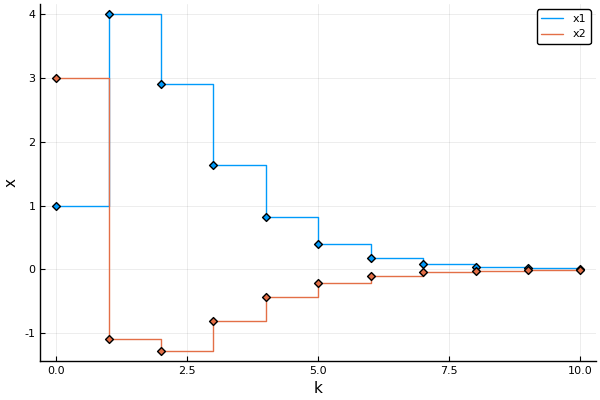

In [37]:
plot(0:N,hcat(x0,xopt)',marker=:diamond,label=["x1" "x2"],linetype=:steppost)
xlabel!("k")
ylabel!("x") # beware the conflict in notation: x_1 vs x_k. I could have used x(k) for dependence on the discrete time.

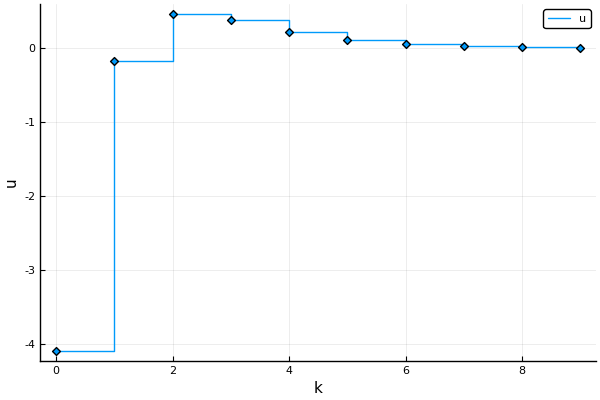

In [38]:
plot(0:(N-1),uopt',marker=:diamond,label="u",linetype=:steppost)
xlabel!("k")
ylabel!("u")

## Sequential (condensed) formulation

In the alternative formulation of the optimization problem, we eliminate the states altogether by expressing them as functions of the inputs. The resulting optimization is then conducted only over the controls $u$ and (and the initial state $x_0$ should it be left free). 

\begin{equation}
 \tilde J(\mathbf u,\mathbf x_0) = \frac{1}{2}\mathbf u^T\mathbf H\mathbf u +  \mathbf x_0^T\mathbf F^T \mathbf u.
\end{equation} 

If no additional constraints are imposed (in particular, the bound constraints on the controls), the problem boils down to solving linear equations.

$$ \mathbf H\mathbf u=-\mathbf F\mathbf x_0,$$

which can be formally written as

$$\mathbf u = -\mathbf H^{-1} \mathbf F \mathbf x_0$$

but it goes without saying that we are certainly not going to compute the invers of the matrix $\mathbf H$,

### Building the linear system (set of linear equations)

In [39]:
Chat = BlockArray(spzeros(N*n,N*m),repeat([n],N),repeat([m],N));
Ahat = BlockArray(spzeros(N*n,n),repeat([n],N),[n]);

In [40]:
for i=1:N
    for j = 1:i
        Chat[Block(i,j)] = sparse(A^(i-j)*B)
        Ahat[Block(i,1)] = sparse(A^i)
    end
end

In [41]:
H = Chat'*Qbar*Chat + Rbar; 
H = Array(H); 

In [42]:
F = Chat'*Qbar*Ahat;
F = Array(F);

### Solving the linear system

The crucial computation step - solving a set of linear equations - comes now

In [43]:
uopts = -H\(F*x0);

It is worth noting that the size of the problem is $n\times n$ and the data (the matrix) is not sparse any more.

### Plotting the responses

Finally, we plot the optimal control sequence and notice that it is identical to the one computed in the simultaneous (sparse) framework.

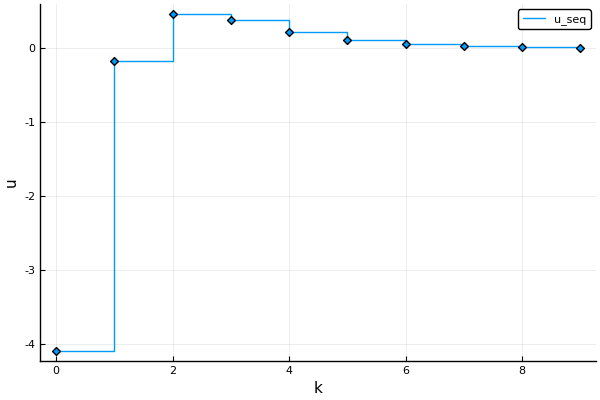

In [44]:
plot(0:(N-1),uopts,marker=:diamond,label="u_seq",linetype=:steppost)
xlabel!("k")
ylabel!("u")

In [45]:
xopts = Chat*uopts + Ahat*x0;
xopts = reshape(xopts,(2,:))

2×10 reshape(::BlockArray{Float64,1,Array{Array{Float64,1},1},Tuple{BlockedUnitRange{Array{Int64,1}}}}, 2, 10) with eltype Float64:
  4.0       2.90983   1.63933    0.827815  …   0.016135     0.00855228
 -1.09017  -1.2705   -0.811515  -0.434556     -0.00758275  -0.00252758

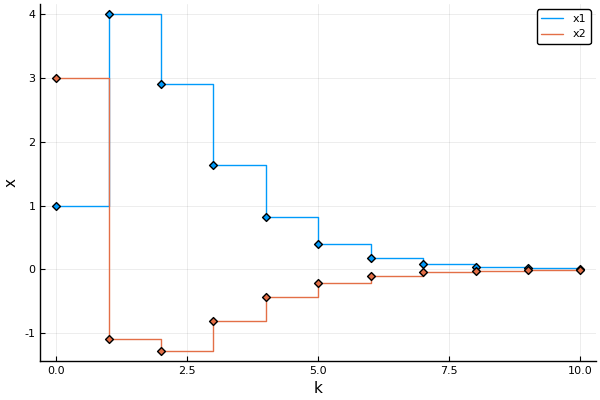

In [46]:
plot(0:N,hcat(x0,xopts)',marker=:diamond,label=["x1" "x2"],linetype=:steppost)
xlabel!("k")
ylabel!("x")

### Imposing constraints on controls

If additional constraints are imposed, namely, the bound constraints on $\mathbf u$, the problem becomes 

In [47]:
u = Variable(N*m)

Variable
size: (10, 1)
sign: real
vexity: affine
id: 174…971

In [48]:
umax = 1

1

In [49]:
problem = minimize(1/2*quadform(u,H) + dot(F*x0,u),[abs(u) <= umax])

minimize
└─ + (convex; real)
   ├─ * (convex; positive)
   │  ├─ 0.5
   │  └─ * (convex; positive)
   │     ├─ …
   │     └─ …
   └─ sum (affine; real)
      └─ .* (affine; real)
         ├─ …
         └─ …
subject to
└─ <= constraint (convex)
   ├─ abs (convex; positive)
   │  └─ 10-element real variable (id: 174…971)
   └─ 1

status: `solve!` not called yet

In [50]:
solve!(problem, SCS.Optimizer)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 166, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 23, constraints m = 46
Cones:	primal zero / dual free vars: 1
	linear vars: 31
	soc vars: 14, soc blks: 2
Setup time: 4.03e-05s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.13e+20  1.59e+22  1.00e+00 -2.83e+21 -0.00e+00  3.26e+21  2.67e-05 
   100| 5.49e-01  7.67e+01  4.60e-03 -1.94e+03 -1.95e+03  1.26e-15  1.24e-03 
   200| 2.59e-02  6.98e+00  7.70e-05 -1.84e

In [51]:
problem.status

OPTIMAL::TerminationStatusCode = 1

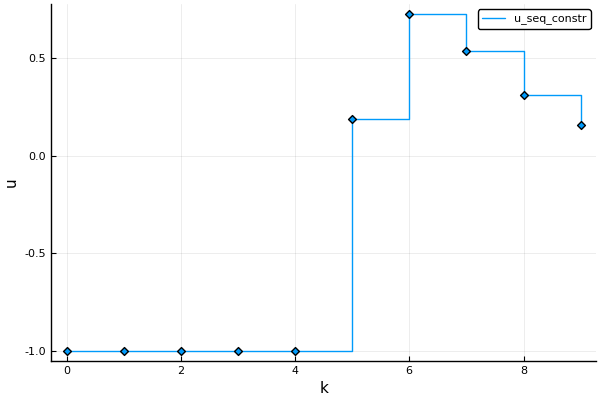

In [52]:
plot(0:(N-1),u.value,marker=:diamond,label="u_seq_constr",linetype=:steppost)
xlabel!("k")
ylabel!("u")

In [53]:
xopts = Chat*u.value + Ahat*x0;
xopts = reshape(xopts,(2,:))

2×10 reshape(::BlockArray{Float64,2,Array{Array{Float64,2},2},Tuple{BlockedUnitRange{Array{Int64,1}},Base.OneTo{Int64}}}, 2, 10) with eltype Float64:
 4.0  6.0  7.0          7.0   6.0  …   1.10341    0.55488    0.318435 
 2.0  1.0  6.63161e-8  -1.0  -2.0     -0.548532  -0.236446  -0.0788149

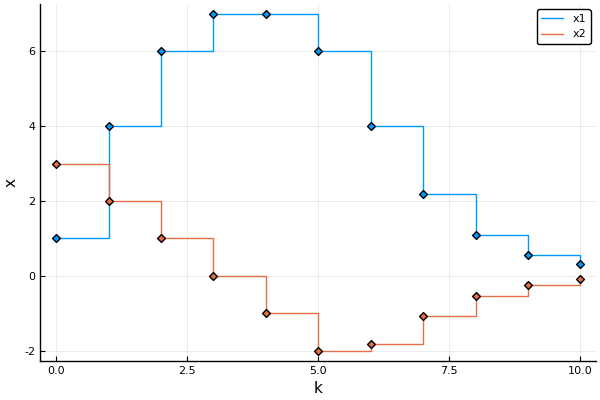

In [54]:
plot(0:N,hcat(x0,xopts)',marker=:diamond,label=["x1" "x2"],linetype=:steppost)
xlabel!("k")
ylabel!("x")

## References

[1] Lewis, Frank, Draguna Vrabie, and Vassilis L. Syrmos. Optimal Control. 3rd edition. Hoboken: Wiley, 2012.

[2] Rawlings, James B., David Q. Mayne, and Moritz M. Diehl. Model Predictive Control: Theory, Computation, and Design. 2nd ed. Madison, Wisconsin: Nob Hill Publishing, LLC, 2017.